# Neural Network for blood cells

**Der Datensatz besteht aus mikroskopischen Bildern von Blutzellen, diese sind in acht Kategorien aufgeteilt:**
1. basophil
2. eosinophil
3. erythroblast
4. ig
5. lymphocyte
6. monocyte
7. neutrophil
8. platelet

## Daten importieren und vorbereiten
Die Daten werden aus dem Verzeichnis geladen und verarbeitet. Die grösse wird auf 224 x 224 Pixel gesetzt und die Bilder werden durchgemischt und in Batches mit je 32 Bildern geladen. 20% der Daten werden zur validation behalten. Die verbleibenden 80% werden erneut aufgeteilt, wobei 80% als Trainingsdaten und 20% als Validierungsdaten dienen. Dies führt zu einem Trainingssatz mit 64%, einem Validierungssatz mit 16% und einem Testdatensatz mit 20% der Bilder.  

In [1]:
import os
import keras

# Import and prepare the first split of datasets
path = os.path.join("images/archive/bloodcells_dataset/")

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Use image_dataset_from_directory to load your data
dataset, test_dataset = keras.utils.image_dataset_from_directory(
    directory=path,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="both",
    shuffle=True,
    seed=42
)

# Get class names
class_names = dataset.class_names
print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


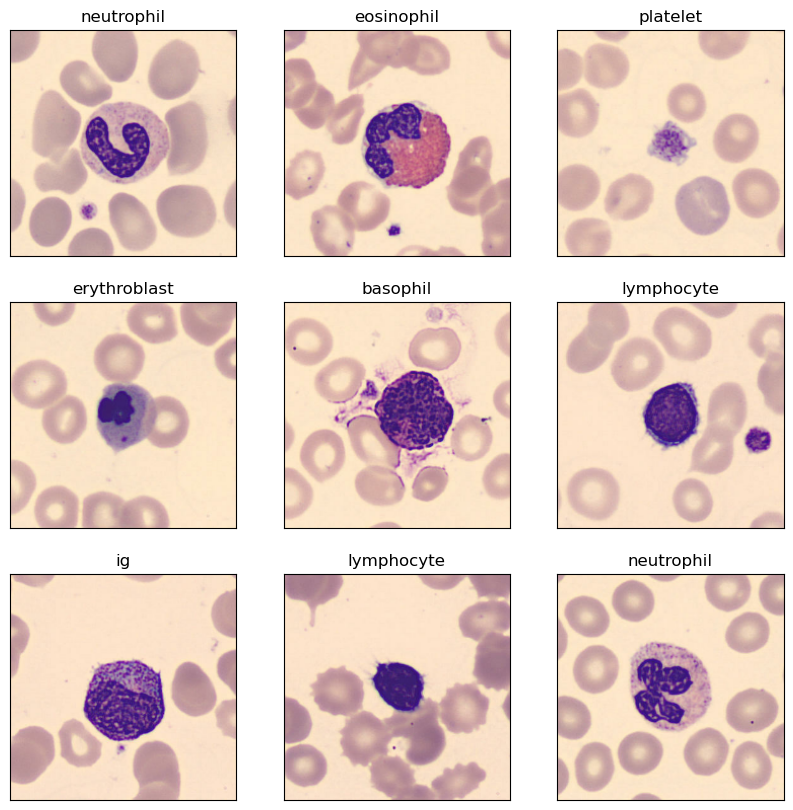

In [2]:
from matplotlib import pyplot as plt

# Plot 16 images from the dataset as examples
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(9):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

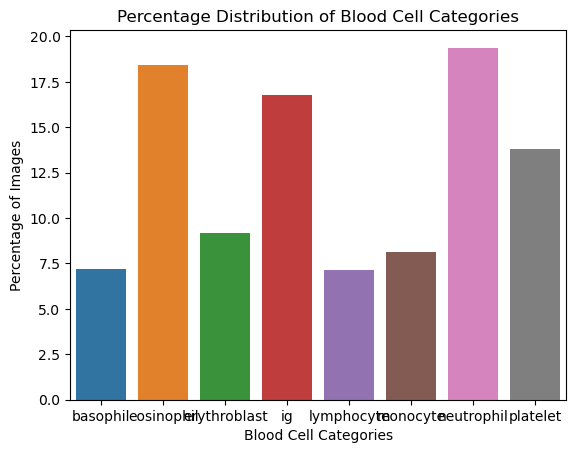

In [3]:
import numpy as np
import seaborn as sns

# Convert labels to NumPy array
labels_array = np.concatenate([labels.numpy() for images, labels in dataset], axis=0)

# Get the class distribution from the dataset
class_distribution = [np.sum(labels_array == i) for i in range(len(class_names))]

# Calculate the percentage distribution
total_samples = sum(class_distribution)
class_percentages = [(count / total_samples) * 100 for count in class_distribution]

# Create a countplot using seaborn with percentages
sns.barplot(x=class_names, y=class_percentages)
plt.xlabel('Blood Cell Categories')
plt.ylabel('Percentage of Images')
plt.title('Percentage Distribution of Blood Cell Categories')
plt.show()

In [4]:
import tensorflow as tf

# Get the total number of elements in the dataset
num_elements = len(dataset)

# Calculate the size of the training set (80% of the total dataset)
train_size = int(0.8 * num_elements)

# Skip the first 'train_size' elements to create the validation dataset
# and prefetch the data for improved performance
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)

# Take the first 'train_size' elements to create the training dataset
# and prefetch the data for improved performance
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check the lengths of the resulting datasets
len(train_dataset), len(val_dataset), len(test_dataset) # Output is in batches, BATCH_SIZE=32

(342, 86, 107)

In [5]:
# Check format of the batches, should be -> (32, 224, 224, 3)
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [6]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(3.4720578, shape=(), dtype=float32)


**Fazit:**
* Die 8 Klassen sind unausgeglichen, wobei die häufigste Klasse die Neutrophilen mit 19,4% aller Bilder und die seltenste Klasse die Lymphozyten mit 7,1% ist. Daher würde die Genauigkeit eines zufälligen Modells 19,4% betragen.
* Die Pixelintensitäten reichen von 3,5 bis 255. Daher ist eine Neuskalierung der Pixelintensitäten angemessen.

## Model 1 - Simple CNN

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

# Implement a call back function. Stopps after quantity stopps improving
callBack = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set the seed for TensorFlow operations
tf.random.set_seed(24)
# Defining a simple CNN model
model1 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), 
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model1.summary()

# Compiling the model
model1.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Training the model
history1 = model1.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[callBack])

result1 = model1.evaluate(test_dataset)

print("Test Loss:", result1[0])
print("Test Accuracy:", result1[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0

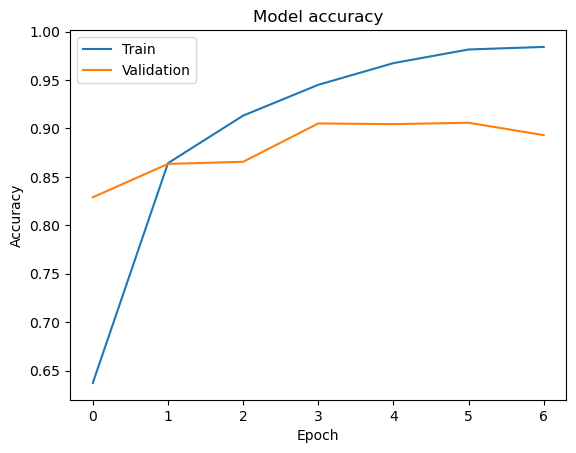

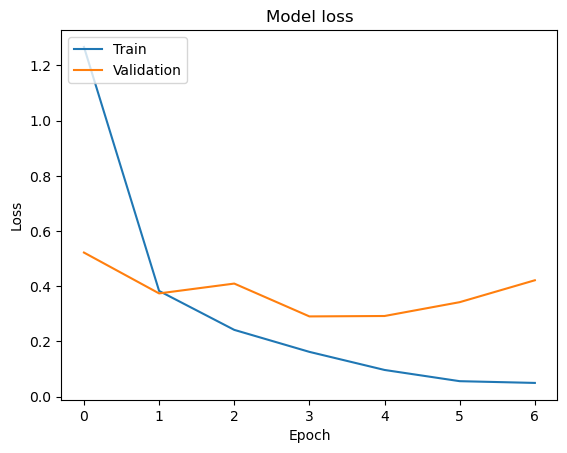

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Model 2 - InceptionV3 model

In [8]:
from  keras.applications import InceptionV3

base_model2 = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
                     include_top=False,
                     weights='imagenet')

base_model2.trainable = False

model2 = keras.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),   
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model2.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model2.summary()

history2 = model2.fit(train_dataset, validation_data=val_dataset, epochs=10)

result2 = model2.evaluate(test_dataset)
print('Test Loss: ', result2[0])
print('Test Accuracy: ', result2[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 22329384 (85.18 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________

Das zweite Modell braucht zu viel Zeit und ist nicht in der Volesung enthalten. Fazit -> Keine verwendung